In [128]:
import numpy as np
import random
from numpy import inf
from copy import deepcopy
import time

move_dict = {
  "A": 0, "a": 0,
  "B": 1, "b": 1,
  "C": 2, "c": 2,
  "D": 3, "d": 3,
  "E": 4, "e": 4,
}

class Teeko:
    def __init__(self, player1, player2):
        self.player1 = (player1, 1)  # Black Player
        self.player2 = (player2, 2)  # Red Player
        self.board = np.zeros((5,5))
        self.turn = 0
        self.current_player = self.player1
    
    def set_player(self, player):
        if player == 1:
            self.current_player = self.player1
        else: self.current_player = self.player2
    
    def switch_player(self):
        if self.current_player == self.player1:
            self.current_player = self.player2
        else: self.current_player = self.player1
        self.turn += 1
        
    def move_translator(self, selected):       #A5, B6 etc.
        yPos = selected[0]
        xPos = int(selected[1]) - 1
        return (move_dict[yPos], xPos)

    def make_a_move(self, selected, move = None):       # selected recibe posiciones reales tupla, move recibe la dirección  # move
        y, x = selected
        valid_move = True
        if self.board[y][x] != self.current_player[1] and move != None:
            valid_move = False
            return valid_move, selected
        if move is not None:
            for pos in move:
                if pos == "u" and y > 0:
                    y -= 1
                elif pos == "d" and y < 4:
                    y += 1
                elif pos == "r" and x < 4:
                    x += 1 
                elif pos == "l" and x > 0: 
                    x -= 1
                else: 
                    valid_move = False
        if valid_move and self.board[y][x] == 0:
            self.board[selected[0]][selected[1]] = 0
            limit = x >=0 and x < 5 and y >= 0 and y < 5
            if limit:
                selected = (y, x)
                self.board[selected[0]][selected[1]] = self.current_player[1]
            else: 
                print("Limites superados o posición ocupada")
                valid_move = False
        else: 
            print("Movimiento no válido, vuelva a intentarlo")   
            valid_move = False
            
        return valid_move, selected
        
    def check_horizontal(self, y):
        winner = False
        count = 0
        for row in self.board[y]:
            if row == self.current_player[1]:
                count += 1
            else: count = 0
            if count == 4:
                winner = True
        return winner

    def check_vertical(self, x):
        winner = False
        count = 0
        for col in range(5):
            if self.board[col][x] == self.current_player[1]:
                count += 1
            else: count = 0
            if count == 4:
                winner = True
        return winner
    
    def check_diagonal(self, matrix):
        winner = False
        count = 0
        for k in range(3):
            arr = np.diag(matrix, k - 1)
            for x in arr:
                if x == self.current_player[1]:
                    count += 1
                else: count = 0
                if count == 4:
                    winner = True
            if winner:
                break
        return winner
    
    def check_square(self, x, y):
        winner = False
        count = 0
        for i in range (2):
            if y + 1 < 5 and x + i < 5:
                if self.board[y][x + i] == self.current_player[1]:
                    count += 1
                if self.board[y + 1][x + i] == self.current_player[1]:
                    count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y - 1 >= 0 and x + i < 5:
                    if self.board[y][x + i] == self.current_player[1]:
                        count += 1
                    if self.board[y - 1][x + i] == self.current_player[1]:
                        count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y + 1 < 5 and x - i >= 0:
                    if self.board[y][x - i] == self.current_player[1]:
                        count += 1
                    if self.board[y + 1][x - i] == self.current_player[1]:
                        count += 1
        if count != 4:
            count = 0
            for i in range (2):
                if y - 1 >= 0 and x - i >= 0:
                    if self.board[y][x - i] == self.current_player[1]:
                        count += 1
                    if self.board[y - 1][x - i] == self.current_player[1]:
                        count += 1
        if count == 4:
            winner = True
        return winner

    def check_winner(self, last_position): #0,1 2,0
        y, x = last_position
        count = 0
        winner = False
        winner = self.check_horizontal(y)
        if not winner:
            winner = self.check_vertical(x)
        if not winner:
            winner = self.check_diagonal(self.board)
        if not winner:
            winner = self.check_diagonal(np.fliplr(self.board))
        if not winner:
            winner = self.check_square(x, y)
        return winner  
    
    def get_position(self):
        arr_pos = []
        phase1 = False
        if np.count_nonzero(self.board > 0) != 8:
            phase1 = True
        for y in range(5):
            for x in range(5):
                if phase1:
                    if self.board[y][x] == 0:
                        arr_pos.append((y,x))
                else:
                    if self.board[y][x] == self.current_player[1]:
                        arr_pos.append((y,x))
        return arr_pos
    
    def get_actions(self, selected):
        y, x = selected
        actions = ['u', 'd', 'l', 'r', 'ul', 'ur', 'dl', 'dr']
        valid_move = True
        valid_actions = []
        if np.count_nonzero(self.board > 0) != 8:
            return [None]
        for action in actions:
            valid_move = True
            y, x = selected
            for pos in action:
                if pos == "u" and y > 0:
                    y -= 1
                elif pos == "d" and y < 4:
                    y += 1
                elif pos == "r" and x < 4:
                    x += 1 
                elif pos == "l" and x > 0: 
                    x -= 1
                else: 
                    valid_move = False
            if valid_move and self.board[y][x] == 0:
                valid_actions.append(action)
        return valid_actions
    
    def heuristic(self, position):
        strength = 0
        mat = [[4,6,5,6,4],[6,10,10,10,6],[5,10,12,10,5],[6,10,10,10,6],[4,6,5,6,4]]
        
        for y in range(5):
            for x in range(5):
                if self.board[y][x] == self.player1[1]:
                    strength += mat[y][x]
                if self.board[y][x] == self.player2[1]:
                    strength -= mat[y][x]
        if self.current_player[0] == "MAX":
            strength -= self.turn * 2
        if self.current_player[0] == "MIN":
            strength += self.turn * 2
        if self.check_winner(position):
            if self.current_player[0] == "MAX":
                strength += 100
            if self.current_player[0] == "MIN":
                strength -= 100
        return strength

In [129]:
#Minimax Algorithm

def minmax_decision(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value(copyGame, selected)
                values.append(value)
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value(copyGame,selected)
                values.append(value)
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]


def min_value(game, last_position):
    actions = []
    value = inf
    if game.check_winner(last_position):
        value = game.heuristic(last_position) #nos falta la heurística
        game.switch_player()
    else:
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min(value, max_value(copyGame, selected))
    return value

def max_value(game, last_position):
    actions = []
    value = -inf
    if game.check_winner(last_position):
        value = game.heuristic(last_position) #nos falta la heurística
        game.switch_player()
    else:
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions: 
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max(value, min_value(copyGame, selected))
    return value

def min(value1, value2): #return the minimum value
    if value1 < value2:
        return value1
    else:
        return value2

def max(value1, value2): #return the max value
    if value1 > value2:
        return value1
    else:
        return value2

In [130]:
#Alpha Beta Pruning Algorithm

def alpha_beta_search(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_pruning(copyGame, selected,-inf, inf)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_pruning(copyGame, selected,-inf, inf)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_pruning(self, game, last_position, alpha, beta):
    actions = []
    v = inf
    if game.check_winner(last_position):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_pruning(copyGame, selected,alpha, beta))
                if v <= alpha:
                    return v
                beta = min(beta,v)
    return v

def max_value_pruning(self, game, last_position, alpha, beta):
    actions = []
    v = -inf
    if game.check_winner(last_position):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_pruning(copyGame, selected,alpha, beta))
                if v >= beta:
                    return v
                alpha = max(alpha,v)
    return v


In [131]:
#Minimax with depth Algorithm (w/o Alpha Beta Pruning)

max_depth = 3

def min_max_with_depth_no_ABP(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth_no_ABP(copyGame, selected, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth_no_ABP(copyGame, selected, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth_no_ABP(game, last_position, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth_no_ABP(copyGame, selected, depth + 1))
    game.switch_player()
    return v

def max_value_with_depth_no_ABP(game, last_position, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth_no_ABP(copyGame, selected, depth + 1)) 
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

In [132]:
#Minimax with depth Algorithm (w/ Alpha Beta Pruning)


max_depth = 3

def min_max_with_depth(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth(game, last_position, alpha, beta, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth(copyGame, selected,alpha, beta, depth + 1))
                if v <= alpha:
                    return v
                beta = min(beta,v)
    game.switch_player()
    return v

def max_value_with_depth(game, last_position, alpha, beta, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth(copyGame, selected,alpha, beta, depth + 1)) 
                if v >= beta:
                    return v
                alpha = max(alpha,v)
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

In [133]:
#Minimax with depth Algorithm (w/ Alpha Beta Pruning and shuffle)

max_depth = 3

def min_max_with_depth_shuffle(game):  #player MIN MAX, game es de la clase Teeko
    values = []
    i = 0
    mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
    actions = []
    moves = []
    pieces = []
    random.shuffle(mark_position)
    if game.current_player[0] == "MAX":
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = min_value_with_depth_shuffle(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmax(values)
    else:
        for mark in mark_position:
            actions = game.get_actions(mark)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                value = max_value_with_depth_shuffle(copyGame, selected,-inf, inf, 0)
                values.append(value) 
                moves.append(action)
                pieces.append(mark)
        i = np.argmin(values)
    return moves[i], pieces[i]

def min_value_with_depth_shuffle(game, last_position, alpha, beta, depth):    
    actions = []
    v = inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        random.shuffle(mark_position)
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = min(v, max_value_with_depth_shuffle(copyGame, selected,alpha, beta, depth + 1))
                if v <= alpha:
                    return v
                beta = min(beta,v)
    game.switch_player()
    return v

def max_value_with_depth_shuffle(game, last_position, alpha, beta, depth):
    actions = []
    v = -inf
    if cut_off(game, last_position, depth):
        v = game.heuristic(last_position)
        game.switch_player()
        return v
    else: 
        game.switch_player()
        mark_position = game.get_position() # el get devuelve un array de tuplas de las posiciones de todas las fichas del current_player 
        random.shuffle(mark_position)
        for mark in mark_position:
            actions = game.get_actions(mark)
            random.shuffle(actions)
            for action in actions:
                copyGame = deepcopy(game)
                b, selected = copyGame.make_a_move(mark, action)
                v = max(v, min_value_with_depth_shuffle(copyGame, selected,alpha, beta, depth + 1)) 
                if v >= beta:
                    return v
                alpha = max(alpha,v)
    game.switch_player()
    return v

def cut_off(game, last_position, depth):
    return depth == max_depth or game.check_winner(last_position)

In [134]:
#Juego
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plot
    
def plot_game(game):
    plot.matshow(game.board)
    colors = 'white black red'.split()
    cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)
    plot.title('Gameboard')
    plot.xticks([0,1,2,3,4], ["1","2","3","4","5"])
    plot.yticks([0,1,2,3,4], ["A","B","C","D","E"])
    plot.imshow(game.board, cmap=cmap)
    plot.show()

def order_selection(game):
    print("Select your color: ")
    print("1 .- Black pieces (First Player)")
    print("2 .- Red pieces (Second Player)")
    player_selected = int(input())
    clear_output(wait=False)
    return player_selected

def gameloop():
    winner_found = False
    game = Teeko("MAX", "MIN")
    player_selected = order_selection(game)
    turn = 1
    while winner_found != True:
        if turn > 8:
            if player_selected != game.current_player[1]:
                move, selected_piece = min_max_with_depth_shuffle(deepcopy(game))
                valid_move, selected = game.make_a_move(selected_piece, move)
                winner_found = game.check_winner(selected)
                clear_output(wait=False)
                plot_game(game)
                print(f"== Algoritmo ==")
                print(f"Ficha seleccionada: {selected_piece}")
                print(f"Movimiento: {move}")
            else:
                print(f"== Jugador ==")
                print(f"Ingresar movimiento")
                selected_piece = input()
                move = input()
                selected_translated = game.move_translator(selected_piece)
                valid_move, selected = game.make_a_move(selected_translated, move)
                clear_output(wait=False)
                plot_game(game)
                time.sleep(0.01)
                winner_found = game.check_winner(selected)
        else:
            if player_selected == game.current_player[1]:
                clear_output(wait=False)
                print(f"Ingresar movimiento")
                plot_game(game)
                move = input()
                move_translated = game.move_translator(move)
                valid_move, selected = game.make_a_move(move_translated)
                clear_output(wait=False)
                plot_game(game)
                winner_found = game.check_winner(move_translated)
                
                time.sleep(0.01)
            else:
                move, selected_piece = min_max_with_depth_shuffle(deepcopy(game))
                valid_move, selected = game.make_a_move(selected_piece)
                clear_output(wait=False)
                plot_game(game)
                winner_found = game.check_winner(selected)

        if not winner_found and valid_move:                             #Si el jugador realiza un movimiento invalido repite su turno
                game.switch_player()
                turn += 1
    print(f"El jugador ganador es: {game.current_player}")
    return 0


# GAME

Ingresar movimiento


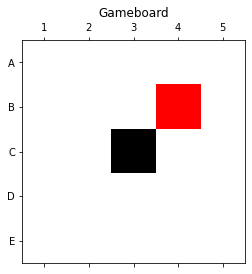

IndexError: string index out of range

In [135]:
gameloop()